## Demo 3 - Uma implementação de DCGANs usando a técnica de convolução transposta e a biblioteca Keras.

- Dados

Redimensionar as imagens do CIFAR-10 entre -1 e 1.

- Gerador

Usar o inverso da convolução, chamada de convolução transposta.

Ativação de ReLU e BatchNormalization.

A entrada para o gerador é a distribuição normal z ou amostra latente (100 valores).

A última ativação é tanh.

- Discriminador

Usamos uma rede neural convolucional.

Ativação LeakyReLU e BatchNormalization.

A última ativação é sigmóide.

- Perda

binary_crossentropy

- Otimizador

Adam (lr = 0,0003, beta_1 = 0,5)
batch_size = 64
épocas = 100

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


In [3]:
# Carregando nosso dataset

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 93s 1us/step


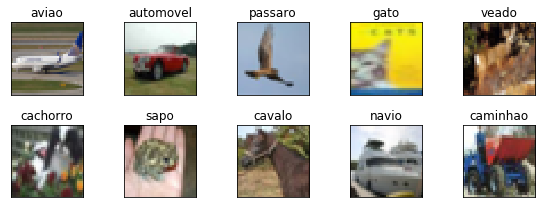

In [4]:
num_classes = len(np.unique(y_train))
class_names = ['aviao','automovel','passaro','gato','veado',
               'cachorro','sapo','cavalo','navio','caminhao']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [5]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

X_train shape: (50000, 32, 32, 3)
50000 amostras de treinamento
10000 amostras de teste


In [6]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# Convertendo nossos vetores de classes para representações 
# em matrizes de classe binárias

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# O gerador está usando a ativação de tanh, para a qual precisamos pré-processar
# os dados da imagem em um intervalo entre -1 e 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [7]:
print(X_train[0].shape)

(32, 32, 3)


In [8]:
# Espaço dimensional latente

z = Input(shape=(100,))

# Classes

labels = Input(shape=(10,))

# Rede geradora

merged_layer = Concatenate()([z, labels])

# FC: 2x2x512

generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256

generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128

generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64

generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3

generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)

generator = Model(inputs=[z, labels], outputs=generator, name='generator')

In [9]:
# Sumário representativo de nosso modelo

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         227328      concatenate_1[0][0]      

In [0]:
# Imagem de entrada

img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64

discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:

discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 

discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 

discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC

discriminator = Flatten()(discriminator)

# Concatenação

merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Saída

discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')

In [11]:
# Sumário representativo de nosso modelo

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_5[0][0]      
______________________________________________________________________________________

In [12]:
# Otimizador

discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [14]:
# Sumário representativo de nosso modelo

d_g.summary()

Model: "adversarial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]        

epoch = 1/200, d_loss=0.274, g_loss=4.804                                                                                                     


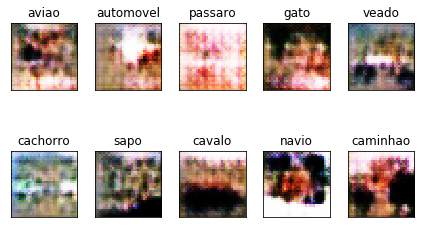

epoch = 2/200, d_loss=0.351, g_loss=4.081                                                                                                     
epoch = 3/200, d_loss=0.434, g_loss=2.753                                                                                                     
epoch = 4/200, d_loss=0.355, g_loss=2.280                                                                                                     
epoch = 5/200, d_loss=0.314, g_loss=2.435                                                                                                     
epoch = 6/200, d_loss=0.883, g_loss=4.293                                                                                                     
epoch = 7/200, d_loss=0.335, g_loss=3.056                                                                                                     
epoch = 8/200, d_loss=0.699, g_loss=6.751                                                                                                     

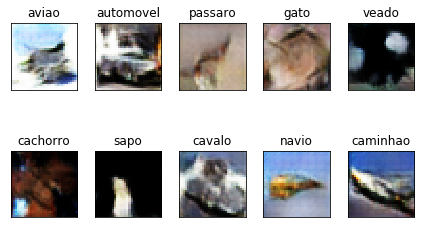

epoch = 12/200, d_loss=0.232, g_loss=5.126                                                                                                     
epoch = 13/200, d_loss=0.339, g_loss=2.386                                                                                                     
epoch = 14/200, d_loss=0.305, g_loss=5.263                                                                                                     
epoch = 15/200, d_loss=0.284, g_loss=8.062                                                                                                     
epoch = 16/200, d_loss=0.231, g_loss=5.002                                                                                                     
epoch = 17/200, d_loss=0.169, g_loss=0.343                                                                                                     
epoch = 18/200, d_loss=0.183, g_loss=0.856                                                                                              

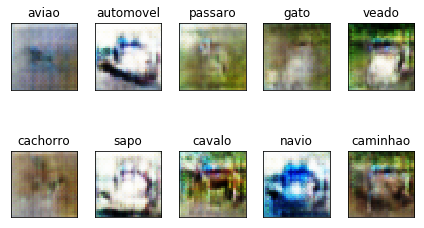

epoch = 22/200, d_loss=0.167, g_loss=12.335                                                                                                     
epoch = 23/200, d_loss=0.164, g_loss=0.161                                                                                                     
epoch = 24/200, d_loss=0.167, g_loss=15.348                                                                                                     
epoch = 25/200, d_loss=0.164, g_loss=6.154                                                                                                     
epoch = 26/200, d_loss=0.164, g_loss=14.156                                                                                                     
epoch = 27/200, d_loss=0.224, g_loss=16.118                                                                                                     
epoch = 28/200, d_loss=0.163, g_loss=0.189                                                                                          

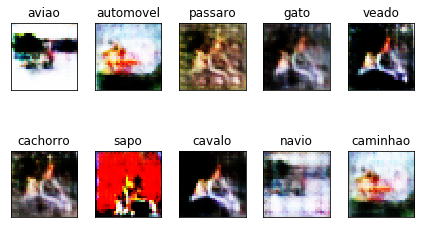

epoch = 32/200, d_loss=0.164, g_loss=16.078                                                                                                     
epoch = 33/200, d_loss=0.163, g_loss=16.118                                                                                                     
epoch = 34/200, d_loss=0.163, g_loss=2.250                                                                                                     
epoch = 35/200, d_loss=0.163, g_loss=15.617                                                                                                     
epoch = 36/200, d_loss=0.163, g_loss=2.899                                                                                                     
epoch = 37/200, d_loss=0.265, g_loss=12.054                                                                                                     
epoch = 38/200, d_loss=0.168, g_loss=16.118                                                                                         

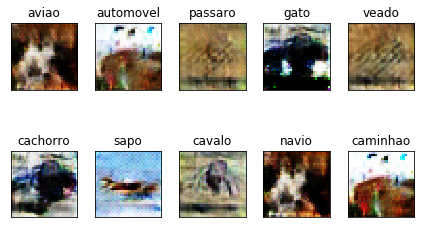

epoch = 42/200, d_loss=0.361, g_loss=15.530                                                                                                     
epoch = 43/200, d_loss=0.170, g_loss=7.593                                                                                                     
epoch = 44/200, d_loss=0.188, g_loss=6.227                                                                                                     
epoch = 45/200, d_loss=0.196, g_loss=6.937                                                                                                     
epoch = 46/200, d_loss=0.172, g_loss=8.460                                                                                                     
epoch = 47/200, d_loss=0.204, g_loss=8.909                                                                                                     
epoch = 48/200, d_loss=0.168, g_loss=9.808                                                                                             

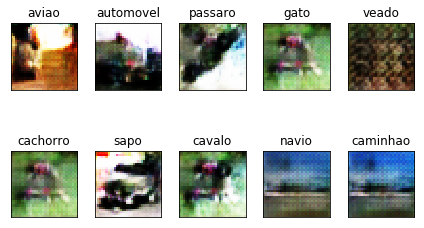

epoch = 52/200, d_loss=0.168, g_loss=12.341                                                                                                     
epoch = 53/200, d_loss=0.446, g_loss=5.383                                                                                                     
epoch = 54/200, d_loss=0.172, g_loss=9.276                                                                                                     
epoch = 55/200, d_loss=0.177, g_loss=9.486                                                                                                     
epoch = 56/200, d_loss=0.179, g_loss=10.542                                                                                                     
epoch = 57/200, d_loss=0.165, g_loss=8.657                                                                                                     
epoch = 58/200, d_loss=0.166, g_loss=13.637                                                                                           

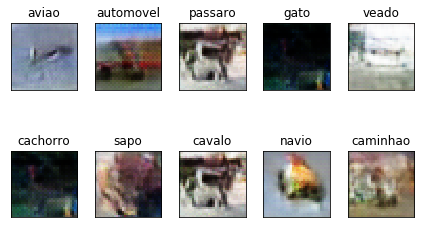

epoch = 62/200, d_loss=0.181, g_loss=3.572                                                                                                     
epoch = 63/200, d_loss=0.171, g_loss=9.956                                                                                                     
epoch = 64/200, d_loss=0.178, g_loss=7.883                                                                                                     
epoch = 65/200, d_loss=0.201, g_loss=4.809                                                                                                     
epoch = 66/200, d_loss=0.200, g_loss=9.847                                                                                                     
epoch = 67/200, d_loss=0.187, g_loss=4.012                                                                                                     
epoch = 68/200, d_loss=0.221, g_loss=11.071                                                                                             

In [0]:
epochs = 200
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Treinamendo os pesos de nosso discriminador
        
        discriminator.trainable = True
        
        # Amostras reais
        
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Amostras falsas
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Perda de nosso discriminador
        
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Treinando os pesos de nosso gerador
        
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

In [0]:
# Plotando nossas métricas de avaliação do modelo

plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()